# Problem 6: Max Cut Problem

Author of the solution: 房伯文

### (a) Numerical optimization

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
N = 5
w = np.array([
    [0, 1, 1, 0, 0],
    [1, 0, 1, 1, 0],
    [1, 1, 0, 0, 1],
    [0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0]
])

def QAOA_circuit(p):
    alpha = ParameterVector('alpha', p)
    beta = ParameterVector('beta', p)
    circ = QuantumCircuit(N)
    circ.h(range(N))
    for k in range(p):
        for i in range(N - 1):
            for j in range(i + 1, N):
                if w[i, j] != 0:
                    circ.rzz(2 * beta[k], i, j)
        for i in range(N):
            circ.rx(-2 * alpha[k], i)
    circ.measure_all()
    return(circ)

In [ ]:
from qiskit_aer import AerSimulator
backend = AerSimulator()
def objfunc(x, p, circ, shots=1000):
    circ2 = circ.assign_parameters(x)
    job = backend.run(circ2, shots=shots)
    result = job.result()
    counts = result.get_counts()
    v = 0
    for b in counts:
        count = counts[b]
        s = 1 - 2 * np.array([int(ch) for ch in b])[::-1]
        E = s @ w @ s / 2   # Use the adjacency matrix to calculate '#cut - #others'
        v = v + E * count   # Calculate the expectation of energy
    v = v / shots
    return(v)

In [8]:
def grad(x, p, circ, shots=1000):
    delta = 1 / shots**(1/6)
    v = np.zeros(2 * p)
    dx = np.zeros(2 * p)
    for i in range(2 * p):
        dx[i] = delta
        f1 = objfunc(x + dx, p, circ, shots)
        f2 = objfunc(x - dx, p, circ, shots)
        dx[i] = 0
        v[i] = (f1 - f2) / 2 / delta
    return(v)

In [23]:
from scipy.optimize import minimize
p = 3
circ = QAOA_circuit(p)
shots = 1000
def callback(x):
    callback.history.append(objfunc(x, p, circ, shots))
alpha0 = 0.1 * np.array([3, 2, 1]) / 3
beta0 = 0.1 * np.array([1, 2, 3]) / 3
x0 = np.concatenate((alpha0, beta0))

cut_best = -np.inf
x_best = None
final_cuts = []
for run in range(20):
    callback.history = []
    sol = minimize(objfunc, x0, args=(p, circ, shots),
                method="BFGS", jac=grad, callback=callback)
    history = callback.history
    cut_num = history[-1]
    final_cuts.append(-cut_num)
    if -cut_num > cut_best:
        cut_best = -cut_num
        x_best = sol.x
    print(callback.history)
    print(-cut_num)

[np.float64(-0.732), np.float64(-0.938), np.float64(-0.824), np.float64(-0.914), np.float64(-1.116), np.float64(-1.422), np.float64(-1.51), np.float64(-1.522), np.float64(-1.574), np.float64(-1.624), np.float64(-1.498), np.float64(-1.71), np.float64(-1.954), np.float64(-2.014), np.float64(-2.146), np.float64(-2.386), np.float64(-2.394), np.float64(-2.384), np.float64(-2.44)]
2.44
[np.float64(-2.086), np.float64(-3.056)]
3.056
[np.float64(-0.654), np.float64(-0.588), np.float64(-0.888)]
0.888
[np.float64(-2.116), np.float64(-2.746), np.float64(-2.806), np.float64(-2.832), np.float64(-2.93), np.float64(-2.974), np.float64(-3.006), np.float64(-3.088), np.float64(-3.118), np.float64(-3.148)]
3.148
[np.float64(-2.19), np.float64(-2.538), np.float64(-2.828)]
2.828
[np.float64(-1.988), np.float64(-2.208), np.float64(-2.634), np.float64(-2.732), np.float64(-2.85), np.float64(-2.852), np.float64(-2.842), np.float64(-3.128), np.float64(-3.134), np.float64(-3.058), np.float64(-3.388), np.float64(

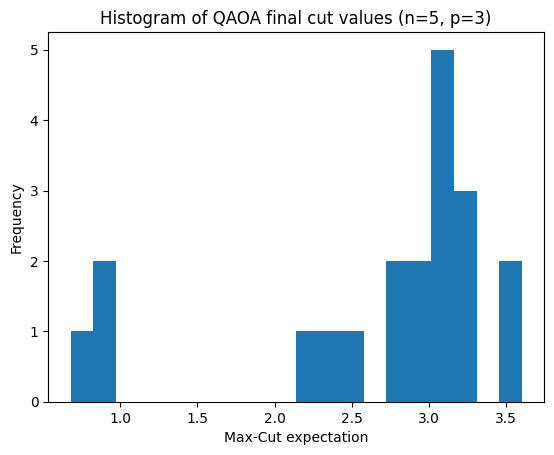

In [24]:
import matplotlib.pyplot as plt
plt.hist(final_cuts, bins=20)
plt.xlabel('Max-Cut expectation')
plt.ylabel('Frequency')
plt.title('Histogram of QAOA final cut values (n=5, p=3)')
plt.show()

### (b) Standard Deviation

In [25]:
def objfunc_std(x, p, circ, shots=1000):
    circ2 = circ.assign_parameters(x)
    job = backend.run(circ2, shots=shots)
    result = job.result()
    counts = result.get_counts()
    v = 0   # <E>
    v2 = 0   # <E^2>
    for b in counts:
        count = counts[b]
        s = 1 - 2 * np.array([int(ch) for ch in b])[::-1]
        E = s @ w @ s / 2   # Use the adjacency matrix to calculate '#cut - #others'
        v = v + E * count   # Calculate the expectation of energy
        v2 = v2 + E**2 * count
    v = v / shots
    v2 = v2 / shots
    std = np.sqrt(v2 - v**2)
    return v, std

In [28]:
mean, std = objfunc_std(x_best, p, circ, shots=1000)
print("Standard Deviation is:", std)
print("Corresponding max_cut: (calculated two times)", -mean, cut_best)
print("Corresponding parameter:", x_best)

Standard Deviation is: 1.130930590266264
Corresponding max_cut: (calculated two times) 3.614 3.602
Corresponding parameter: [0.51316052 0.40428334 0.19172075 0.27909515 0.48987141 0.5311679 ]


### Acknowledgement:
- Due to computational limit, I only run this algorithm for 20 iterations.